# CS110 Final: Plagiarism Detector

Suppose each student submission is a string that is a result of concatenating all the words there (i.e., white spaces are removed). Let X and Y be two student submission strings. Find all the common substrings of length k (known as k-gram) of the two strings. In other words, determine all (i,j) where X[i:i+k]=Y[j:j+k].

For example, X="today is Monday", Y="day".
All possible (i,j) from these two strings are (2,0) and (10,0) for k=3 (“day" appears twice in X, and we disregard the white spaces).

1.You will build the first implementation to solve the problem stated above. The algorithm is as follows:
* Store all length-k substrings of X into a hash table TX with the hash values computed by using rolling
hashing.
* For each substring sy in Y, compute the hash value h(sy) using rolling hashing, and use this hash value to look up sy in table TX. If the lookup is successful, then we have a common substring.

Using this algorithm, complete the function below. There is a lot to fill in as you write the code:
* You will need to specify q for the hash function a mod q in rolling hashing. However, do not worry about fine-tuning q—so long as you choose a prime number and provide a justification for why your chosen value of q makes sense with regards to the table size.
* Other design choices should be thoroughly justified, including but not limited to: the hash table’s size, data structures used, and any additional Python functions.
* No external libraries should be used, except for math, random, and numpy.

Demonstrate that your code works as expected by testing it with at least three, non-trivial test cases.

In [1]:
def first_hash(substring, base, q):
    '''
    Converts a string to a hash value within the table size (q) limit by multiplying each ascii 
    character integer (value - ascii '0') by the base to decreasing powers.
    Eg. 'cat'= 51*base^2 + 49*base^1 + 68*base^0
    
    Parameters
    ----------
    substring: str
        substring for which to compute the hash value
    base: int
        multiplier for individual letter values
    q: int
        table size (prime number)
    
    Returns
    ---------
    int
        an index within the table size (hashed substring value)
    '''
    string_int = 0
    n = len(substring)
    
    # sum all individual letters -> overall integer for string
    for i in range(n):
        
        # subtract ord('0') to decrease large computations
        string_int += (ord(substring[i])-ord('0')) * base**(n-i-1)
        
    # mod q ensures hash value key sits within table size
    return string_int % q


def subsequent_hash(substring, prev_hash, next_letter, base, q):
    '''
    Converts string to a hash value within the limits of the hash table (q) using the previous 
    strings hash value (rolling hashing). Function will produce the same hash value key for the 
    substring as calling first_hash.
    
    Parameters
    ----------
    substring: str
        substring for which to compute the hash value
    prev_hash: int
        key computed for the previous substring
    next_letter: char
        character to add to the end of the previous substring
    base: int 
        multiplier for individual letter values
    q: int
        table size (prime number)
        
    Returns
    --------
    int
        an index within the table size (hashed substring value)
    '''
    # power of base for subsequent string
    m = len(substring)
    
    # add next character to end
    add_next = (prev_hash*base + (ord(next_letter)-ord('0'))) % q

    # remove starting character of current substring
    return (add_next - (ord(substring[0])-ord('0'))*((base**m) % q)) % q


def hash_1(hash_value, q):
    '''
    Computes hash function 1 for use in double hashing.
    
    Parameters
    ----------
    hash_value: int
        the value of the hash for the current substring
    q: int
        prime number table size
        
    Returns
    ---------
    int
        hash value 1 (within table size)
    '''
    return hash_value % q


def hash_2(hash_value, value, table_size):
    '''
    Computes hash function 2 for use in double hashing.
    
    Parameters
    ----------
    hash_value: int
        the value of the hash for the current substring
    value: int
        to compute iterator value in double hashing
        
    Returns
    ---------
    int
        hash value 2
    '''
    # accounts for potential iterating over same index
    if value - (hash_value % value) != table_size:
        return value - (hash_value % value)
    
    return value - (hash_value % value) - 1
    
def first_string_table_creator(string, k, base, table_size):
    '''
    Creates a hash table for a string using rolling hashing. When collisions occur, double
    hashing is used to find new indexes.
    
    Parameters
    ----------
    string: str
        string for which to create the table
    k: int
        length of each substring to store in table
    base: int
        to compute hash values
    table_size: int
        size of hash table (must be larger than string length - k, and a prime number)
    
    Returns
    ---------
    hash_table: dict
        hash table storing all contiguous length k substrings in input string, as well as 
        the index at which they are found in the initial string
    '''
    #initialise hash table
    keys = [i for i in range(table_size)]
    hash_table = {key: None for key in keys}

    for i in range(len(string)-k+1):
        substring = string[i:i+k]
        
        # first iteration, we have no previous hash, therefore must call from beginning
        if i==0:
            prev_hash = first_hash(substring, base, table_size)
            hash_table[prev_hash] = [substring, i]
            
        else:
            # subsequent hash takes previous string (1 before current substring)
            prev_hash = subsequent_hash(string[i-1:i+k-1], prev_hash, string[i+k-1], base, table_size)
            
            # if slot unoccupied, it can be filled
            if hash_table[prev_hash] == None:
                hash_table[prev_hash] = [substring, i]

            # if slot already full, try to find new one using double hashing
            else:
                iterator = 1
                new_index = prev_hash
                hash1 = hash_1(prev_hash, table_size)
                hash2 = hash_2(prev_hash, base, table_size)
                
                # run until unoccupied slot found
                while hash_table[new_index] is not None:
                    new_index = (hash1 + iterator*hash2) % table_size
                    iterator += 1
                    
                    # table full!
                    if iterator == table_size:
                        raise ValueError('no room left in hash table, increase table size')
                
                # insert at new index found through double hashing
                hash_table[new_index] = [substring, i]

    return hash_table


def lookup(prev_hash, base, substring, hash_table, table_size):
    '''
    Searches for a substring in a given hash table, returning the list of indexes at which it 
    can be found.
    
    Parameters
    ----------
    prev_hash: int
        value of prev_hash to compute double hashing resolution indexes
    base: int
        to compute hash values in double hashing
    substring: str
        substring to find in table
    hash_table: dict
        hash table in which to find substring
    table_size: int
        prime number table size
    
    Returns
    ---------
    matched_indexes: lst
        indexes at which substring is found in hash table
    '''
    matched_indexes = []
    iterator = 1
    
    # new_index changed with each iteration below, prev_hash must remain same to calculate hash values
    new_index = prev_hash
    hash1 = hash_1(prev_hash, table_size)         
    hash2 = hash_2(prev_hash, base, table_size)
        
    # run until unoccupied slot found or entire table iterated through
    while hash_table[new_index] is not None and iterator < table_size:
        
        # accounts for same index, different substring
        if hash_table[new_index][0] == substring:
            matched_indexes.append(hash_table[new_index][1]) 

        new_index = (hash1 + iterator*hash2) % table_size
        iterator += 1
                       
    return matched_indexes

    
def rh_get_match(x, y, k, table_size = 104729):
    '''
    Finds indexes of matching substrings of length k between string x and y.
    Eg. Output [(0, 4), (6, 10)] indicates the substring starting at index 0 in string x matches that at index 4 
    in string y, and that starting at index 6 in x matches index 10 in y.
    
    Parameters
    ----------
    x: str
        first string on which a table is made
    y: str
        second string (substrings of which are searched for in table created by x)
    k: int
        length of substrings
    table_size: int
        length of table size, a prime number larger than string length x
        
    Returns
    --------
    matches: lst 
        list of tuples containing indexes that contain matching substrings between x and y
    '''
    base = 33
    matches = []
    
    # creates hash table for k-length substrings in x
    hash_table = first_string_table_creator(x, k, base, table_size)
    
    for i in range(len(y)-k+1):
        substring = y[i:k+i]
        
        if i==0:
            prev_hash = first_hash(substring, base, table_size)
        else:
            prev_hash = subsequent_hash(y[i-1:k+i-1], prev_hash, y[i+k-1], base, table_size)

        match_list = lookup(prev_hash, base, substring, hash_table, table_size)
        
        # append indexes of matches to list of matches (none if list empty)
        for m in match_list:
            matches.append((m, i))

    return matches

In [2]:
def clean_string(string):
    '''
    Removes bad characters, new lines, tabs, and spaces from a string.
    
    Parameters
    ----------
    string: str
        string from which to remove bad characters and spaces
    
    Returns
    ---------
    clean_string: str
        cleaned string without bad characters and spaces
    '''
    # remove bad characters
    bad_chars = [';', ',', '.', '?', '!', '-', '_', '[', ']', '(', ')', '^', '<', '>']
    no_bad_chars_string = ''.join(c for c in string if c not in bad_chars)
    
    # remove spaces, tabs
    no_tabs_string = ''.join(c if (c not in ['\n', '\r', '\t']) else "" for c in no_bad_chars_string)
    clean_string = no_tabs_string.replace(' ', '')
    
    return clean_string

#### Test Cases

In [3]:
# some basic test cases

x = 'helloworldlowa'
y = 'getdownlowandlower'
k = 3
assert rh_get_match(x, y, k, 19) == [(3, 7), (10, 7), (11, 8), (9, 12), (3, 13), (10, 13)]

# completely matching, k=1 should return all indexes
h = 'day'
j = 'day'
k = 1
assert rh_get_match(h, j, k, 7) == [(0, 0), (1, 1), (2, 2)]

# changing k
l = 'itsaverynicedaytodayisntitbaby'
m = 'nicetomeetyoubabyboy'
k = 4
assert rh_get_match(l, m, k, 29) == [(8, 0), (26, 13)]

# numbers should still provide matches
n = '94meadowavenue'
o = '94mewsave'
k = 3
assert rh_get_match(n, o, k, 13) == [(0, 0), (1, 1), (8, 6)]

# capitals should still run through algorithms, but not match ('p'!='P')
p = 'EnvironmentalProtectionAgency'
q = 'theyshouldhaveacertainprotectioninthelocalenvironment'
k = 10
assert rh_get_match(p, q, k, 29) == [(1, 43)]

In [4]:
# random test case (run multiple times for multiple test cases)

import random

random_string_1 = ''
random_string_2 = ''
for i in range(10000):
    # full range of ascii capitals, lowercase, numbers, and some symbols 
    random_string_1 += chr(random.randint(48, 122))
    random_string_2 += chr(random.randint(48, 122))

random_string_1 = clean_string(random_string_1)
random_string_1 = clean_string(random_string_2)

k = 4
matches_1 = rh_get_match(random_string_1, random_string_2, k, 15013)

for m in matches_1:
    assert random_string_1[m[0]:m[0]+k] == random_string_2[m[1]:m[1]+k]

#### Deciding Optimal Table Sizes and Load Factor

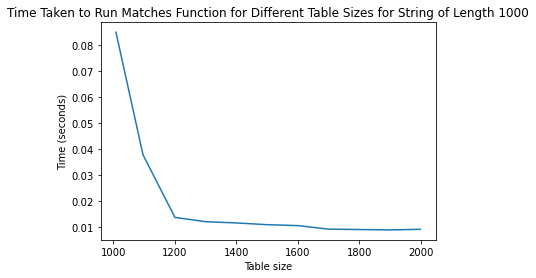

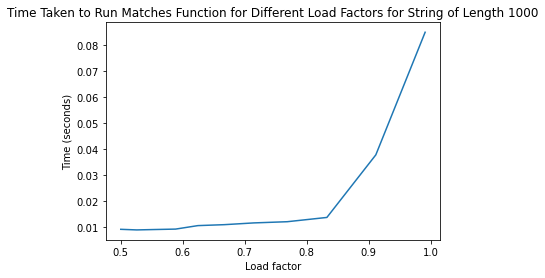

In [5]:
import matplotlib.pyplot as plt
import time

# table sizes ranging from load factor ~1 to ~0.5
table_sizes = [1009, 1097, 1201, 1301, 1399, 1499, 1601, 1699, 1801, 1901, 1999]
times_for_each = [0 for i in range(len(table_sizes))]
times = []
n = 10

for i in range(n):
    
    random_string_1 = ''
    random_string_2 = ''
    for i in range(1000):
        random_string_1 += chr(random.randint(97, 122))
        random_string_2 += chr(random.randint(97, 122))
    
    for i in range(len(table_sizes)):
        start = time.time()
        rh_get_match(random_string_1, random_string_2, 3, table_sizes[i])
        end = time.time()
        times_for_each[i] += (end-start)

for i in times_for_each:
    times.append(i/n)

# table sizes plot
plt.plot(table_sizes, times, label = 'Table sizes')
plt.xlabel('Table size')
plt.ylabel('Time (seconds)')
plt.title('Time Taken to Run Matches Function for Different Table Sizes for String of Length 1000')
plt.show()

# load factors plot
load_factors = [1000/t for t in table_sizes]
plt.plot(load_factors, times, label = 'Load factor')
plt.xlabel('Load factor')
plt.ylabel('Time (seconds)')
plt.title('Time Taken to Run Matches Function for Different Load Factors for String of Length 1000')
plt.show()

As you can see from the above plots, the time taken for the function to run is significantly increased when we have a table size that is not much greater than the input string length. Looking at the second plot regarding load factors, the critical bend appears to occur at about 0.8 load factor. Above this value, very frequent collisions occur, leading to a large time for the algorithm to run. For this reason, it makes sense to use a table size that is about 1.25 times the length of the input string. The downside to this is that we must use extra memory to store a larger dictionary which contains entries without values.

For an application in which we have a lot of memory available, and we want the algorithm to run as quickly as possible (maybe for very long input strings), we may choose to use an even smaller load factor, closer to 0.5 or even smaller. On the other hand, for an application in which we have very limited memory, and are using short input strings, we may choose to use an even higher load factor (> 0.8).

#### Deciding Base Value to Reduce Collisions

In [6]:
def first_string_table_creator_cols(string, k, base, table_size):
    '''
    Adapted from first_string_table_creator.
    Computes numbers of collisions that occur at each index in hash table.
    Creates a hash table for a string using rolling hashing. When collisions occur, double
    hashing is used to find new indexes.
    
    Parameters
    ----------
    string: str
        string for which to create the table
    k: int
        length of each substring to store in table
    base: int
        to compute hash values
    table_size: int
        size of hash table (must be larger than string length - k, and a prime number)
    
    Returns
    ---------
    collisions: lst
        gives number of collisions that occur in both regular and double hashing for each
        key in hash table
    '''
    #initialise hash table
    keys = [i for i in range(table_size)]
    hash_table = {key: None for key in keys}
    collisions = [0 for i in range(table_size)]
    
    for i in range(len(string)-k+1):
        substring = string[i:i+k]
        
        # first iteration, we have no previous hash, therefore must call from beginning
        if i==0:
            prev_hash = first_hash(substring, base, table_size)
            hash_table[prev_hash] = [substring, i]
            
        else:
            # subsequent hash takes previous string (1 before current substring)
            prev_hash = subsequent_hash(string[i-1:i+k-1], prev_hash, string[i+k-1], base, table_size)
            
            # if slot unoccupied, it can be filled
            if hash_table[prev_hash] == None:
                hash_table[prev_hash] = [substring, i]

            # if slot already full, try to find new one using double hashing
            else:
                collisions[prev_hash] += 1
                iterator = 1
                new_index = prev_hash
                
                # run until unoccupied slot found
                while hash_table[new_index] is not None:
                    new_index = (hash_1(prev_hash, table_size) + iterator*hash_2(prev_hash, base, table_size)) % table_size
                    iterator += 1
                    #collisions[new_index] += 1
                    
                    # table full!
                    if iterator == table_size:
                        raise ValueError('no room left in hash table, increase table size')
                
                # insert at new index found through double hashing
                hash_table[new_index] = [substring, i]

    return collisions

Total number of collisions: 853


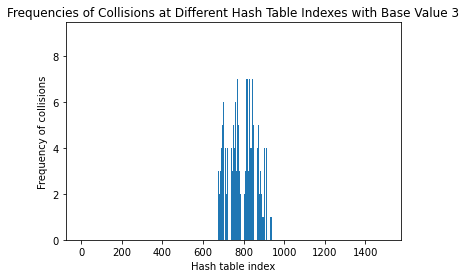

Total number of collisions: 361


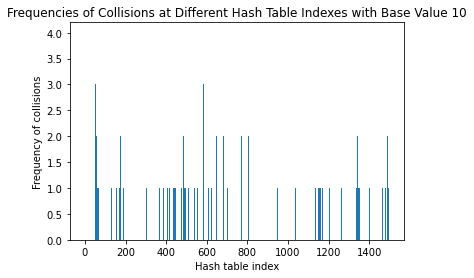

Total number of collisions: 361


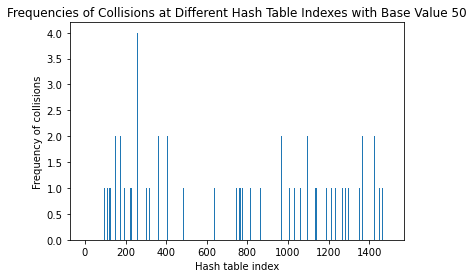

Total number of collisions: 363


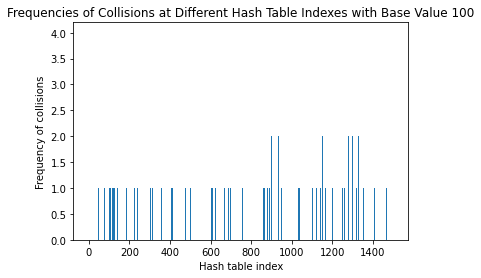

Total number of collisions: 415


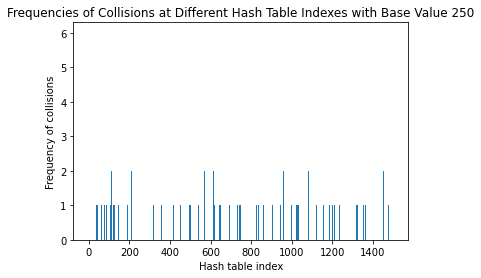

Total number of collisions: 779


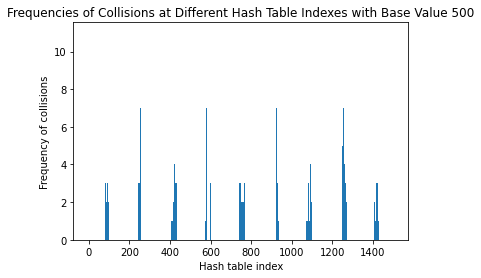

In [7]:
random_string_collisions = ''
for i in range(1000):
    random_string_collisions += chr(random.randint(97, 122))

k = 3
table_size = 1499
bases = [3, 10, 50, 100, 250, 500]

for base in bases:
    collisions = first_string_table_creator_cols(random_string_collisions, k, base, table_size)
    print('Total number of collisions:', sum(collisions))
    plt.bar([i for i in range(table_size)], collisions)
    plt.xlabel('Hash table index')
    plt.ylabel('Frequency of collisions')
    plt.title('Frequencies of Collisions at Different Hash Table Indexes with Base Value '+str(base))
    plt.show()

We want our base value to ensure 2 things:
1. That the keys chosen are uniformly distributed, and therefore we should observe collisions across the entire range of hash table indexes above.
2. The total number of collisions is at a minimum (a consequence of having uniform keys is that the collisions should be reduced).

Considering the above plots for different base values, it seems as though the optimal value to avoid collisions lies around 50.  Below this, we see a single group cluster in which collisions frequently occur, and therefore the total number of collisions is great, and not ideal. Above this, collisions are clustered into periodic groupings of high frequencies. This also leads to a high number of overall collisions which is also not ideal. Base values 20, 50, and 100 all produce graphs that are uniform, and low collision numbers, therefore a choice in this range would be ideal. Similar patterns are observed when we change the string length and table size.

#### Justification of Hashing
* Hashing- The use of hashing in this application reduces insertion and lookup times for the hash table (as will be discussed in question 4). Because every single substring within x needs to be inserted into the hash table, and every substring in y needs to be looked up within the table, the time complexities of these algorithms are very important (as we must perform them many times).
    * Rolling hashing- The use of rolling hashing allows us to compute hash values based on the previous hash value. This means that we don't need to start from scratch everytime we need to compute a hash value for a substring, and therefore reduces the computations. As you can see from the first_hash function above, we must iterate over the length of the substring (k), giving it a time complexity O(k), however the subsequent_hash does not require this iteration, and therefore runs in O(1) time. This function therefore allows us to reduce the overall time complexity, with the limitation that we must have simpler hash functions so that we are able to compute hashes based on the previous hash.
* Alternatively, we may choose a different data structures to build the plagiarism detector, such as a trie tree. In this implementation, we would insert all substrings in x into the tree (each substring would follow a path down the tree from the root to a leaf, and those with common prefixes would share nodes higher up the tree, eg. 'cat' and 'car' would have the same first 2 nodes, bar the root). We must also store the indexes at which the substrings are found in their leaf nodes. We could then lookup each substring from y in the trie tree, appending to a matches list when the word is found. The time complexity of such an approach would likely be O(k(m+n)), O(km) for tree creation, and O(kn) for searching. Though this would also work to solve the problem at hand, we do not require the added functionality of being able to lookup words via their prefixes. Therefore this implementation is possible, but not necessary, as a hash table provides us with an easy method to lookup entire substrings. Furthermore, the time complexity of such an approach grows poor with large values of k. The rolling hash approach will provide a better time complexity (as will be discussed in question 4).
    
#### Justification of Dictionary as Hash Table
* I have used a dictionary to create my hash table in this case as it has allowed me to store both the hash values as keys (to access in lookups), and the values which take the form of lists: [substring, index at which substring is found]. I have chosen a dictionary in this case instead of a list to aid in the debugging process of the algorithm. This allowed me to easily determine which substrings were associated with which hash value keys (rather than having to figure out indexes in a list).
    * Lists as values in hash table dictionary- In order to retrieve the original position of a specific substring within the initial list x, it was necessary to store both the substring and the index at which it was found in the original string. This allowed me to retrieve the indexes within the lookup algorithm.
    
#### Justification of Double Hashing
* The use of double hashing helps to reduce collisions within the hash table when inputting substrings, and create uniformly-distributed values within the table by reducing primary and secondary clustering. There are several alternatives to this method:
    * Linear probing- Though this method is generally simpler as it linearly moves through the table with iterations, it can lead to primary clustering in which the hash table is filled with blocks of values. This often means that many collisions may occur before we find an empty space (long probing sequence), increasing the time complexity of the algorithm.  
    * Quadratic probing- Though this method eliminates the issue of primary clustering as it raises the key to an iterator, it can be subject to secondary clustering, which occurs when 2 keys have the same hash value, and therefore will have the same probing sequence. This can lead to many positions being tried until an empty one is found, therefore increasing the time complexity. Furthermore, the probe sequence is unlikely to move through all possible locations, meaning a table size much larger than the input length x is likely required.
    * Chaining- In this method, when collisions occur, the relevant substring would be linked to the substring at the current hash key. Though this eliminates the need for probing, the sequences attached to keys can become very long, increasing the time taken to search the table, and therefore potentially damaging the O(1) search complexity. In the case that we needed to delete from the table, this method could be advantageous, as the methods used above would require for restructuring of the table after deletion. However, seen as this is not required in plagiarism detection, chaining holds no advantages over open-addressing.

2.You will now work on the second version of this algorithm:
* Store all length-k substrings of X into a hash table TX, using a hash function that does not entail the
division method.
* For each substring sy in Y, compute the hash value h(sy) and use this hash value to look up sy in table TX. If the lookup is successful, then we have a common substring.

Note that using a hash function that does not entail the division method prohibits the use of rolling hashing.
Asymptotically speaking, we are essentially taking more time for computing hash values in this version.
However, we are now free to choose a more fancy function, so there is a tradeoff here.
* Provide a string reflection on what makes a good hash function. Run an experiment to give empirical evidence to support your choice for the hash function.
* Implement the second version of the algorithm described above using the template below. Make sure to:
    * Justify any design choices (the hash function, the hash table’s size, the data structures used, and any additionally built Python functions).
    * Write clean and well-structured code, making use of PEP 8 coding conventions. Because this version only differs from the one in question 1 in how the hash values are computed, try to organize your code in a clear way that reutilizes as much functionality as the one you have already provided code for (for example, consider adding the hashing method either as a positional argument or as a method of choice if you wrap your code in a Python class).
    * No external libraries should be used, except for the math, random, and numpy modules.
* Illustrate how your code works by giving an explicit example. Further, implement at least three test cases to make sure your code works as expected.

In [8]:
def djb2_hash(substring, q):
    '''
    Converts a string to a hash value within the table size (q) using the djb2 algorithm.
    
    Parameters
    ----------
    substring: str
        substring for which to compute the hash value
    base: int
        multiplier for individual letter values
    q: int
        table size (prime number)
    
    Returns
    ---------
    int
        an index within the table size (hashed substring value)
    '''
    n = len(substring)
    hash_value = 5381
    
    for i in substring:
        hash_value = (hash_value * 33) + ord(i)
    
    return hash_value % q


def hash_1(hash_value, q):
    '''
    Computes hash function 1 for use in double hashing.
    
    Parameters
    ----------
    hash_value: int
        the value of the hash for the current substring
    q: int
        prime number table size
        
    Returns
    ---------
    int
        hash value 1 (within table size)
    '''
    return hash_value % q


def hash_2(hash_value, value, table_size):
    '''
    Computes hash function 2 for use in double hashing.
    
    Parameters
    ----------
    hash_value: int
        the value of the hash for the current substring
    value: int
        to compute iterator value in double hashing
        
    Returns
    ---------
    int
        hash value 2
    '''
    # accounts for potential iterating over same index
    if value - (hash_value % value) != table_size:
        return value - (hash_value % value)
    
    return value - (hash_value % value) - 1
    
def reg_first_string_table_creator(string, k, base, table_size):
    '''
    Creates a hash table for a string using rolling hashing. When collisions occur, double
    hashing is used to find new indexes.
    
    Parameters
    ----------
    string: str
        string for which to create the table
    k: int
        length of each substring to store in table
    base: int
        to compute hash values
    table_size: int
        size of hash table (must be larger than string length - k, and a prime number)
    
    Returns
    ---------
    hash_table: dict
        hash table storing all contiguous length k substrings in input string, as well as 
        the index at which they are found in the initial string
    '''
    #initialise hash table
    keys = [i for i in range(table_size)]
    hash_table = {key: None for key in keys}

    for i in range(len(string)-k+1):
        substring = string[i:i+k]
        
        prev_hash = djb2_hash(substring, table_size)
        
        # if slot unoccupied, it can be filled
        if hash_table[prev_hash] == None:
            hash_table[prev_hash] = [substring, i]

        # if slot already full, try to find new one using double hashing
        else:
            iterator = 1
            new_index = prev_hash
            hash1 = hash_1(prev_hash, table_size)
            hash2 = hash_2(prev_hash, base, table_size)
                
            # run until unoccupied slot found
            while hash_table[new_index] is not None:
                #print(substring, new_index)
                new_index = (hash1 + iterator*hash2) % table_size
                iterator += 1
                
                # table full!
                if iterator == table_size:
                    raise ValueError('no room left in hash table, increase table size')
            
            # insert at new index found through double hashing
            hash_table[new_index] = [substring, i]

    return hash_table


def reg_lookup(prev_hash, base, substring, hash_table, table_size):
    '''
    Searches for a substring in a given hash table, returning the list of indexes at which it 
    can be found.
    
    Parameters
    ----------
    prev_hash: int
        value of prev_hash to compute double hashing resolution indexes
    base: int
        to compute hash values in double hashing
    substring: str
        substring to find in table
    hash_table: dict
        hash table in which to find substring
    table_size: int
        prime number table size, default large prime number
    
    Returns
    ---------
    matched_indexes: lst
        indexes at which substring is found in hash table
    '''
    matched_indexes = []
    iterator = 1
    
    # new_index changed with each iteration below, prev_hash must remain same to calculate hash values
    new_index = prev_hash
    hash1 = hash_1(prev_hash, table_size)         
    hash2 = hash_2(prev_hash, base, table_size)
        
    # run until unoccupied slot found or entire table iterated through
    while hash_table[new_index] is not None and iterator < table_size:
        
        # accounts for same index, different substring
        if hash_table[new_index][0] == substring:
            matched_indexes.append(hash_table[new_index][1]) 

        new_index = (hash1 + iterator*hash2) % table_size
        iterator += 1
                       
    return matched_indexes

    
def regular_get_match(x, y, k, table_size = 104729):
    '''
    Finds indexes of matching substrings of length k between string x and y.
    Eg. Output [(0, 4), (6, 10)] indicates the substring starting at index 0 in string x matches that at index 4 
    in string y, and that starting at index 6 in x matches index 10 in y.
    
    Parameters
    ----------
    x: str
        first string on which a table is made
    y: str
        second string (substrings of which are searched for in table created by x)
    k: int
        length of substrings
    table_size: int
        length of table size, a prime number larger than string length x
        
    Returns
    --------
    matches: lst 
        list of tuples containing indexes that contain matching substrings between x and y
    '''
    base = 25
    matches = []
    
    # creates hash table for k-length substrings in x
    hash_table = reg_first_string_table_creator(x, k, base, table_size)
    
    for i in range(len(y)-k+1):
        substring = y[i:k+i]
        
        prev_hash = djb2_hash(substring, table_size)
        match_list = reg_lookup(prev_hash, base, substring, hash_table, table_size)
        
        # append indexes of matches to list of matches (none if list empty)
        for m in match_list:
            matches.append((m, i))

    return matches

#### Test Cases

In [9]:
x = 'helloworldlowa'
y = 'getdownlowandlower'
k = 3
assert regular_get_match(x, y, k, 19) == [(3, 7), (10, 7), (11, 8), (9, 12), (3, 13), (10, 13)]

# completely matching, k=1 should return all indexes
h = 'day'
j = 'day'
k = 1
assert regular_get_match(h, j, k, 7) == [(0, 0), (1, 1), (2, 2)]

# changing k
l = 'itsaverynicedaytodayisntitbaby'
m = 'nicetomeetyoubabyboy'
k = 4
assert regular_get_match(l, m, k, 29) == [(8, 0), (26, 13)]

# numbers should still provide matches
n = '94meadowavenue'
o = '94mewsave'
k = 3
assert regular_get_match(n, o, k, 13) == [(0, 0), (1, 1), (8, 6)]

# capitals should still run through algorithms, but not match ('p'!='P')
p = 'EnvironmentalProtectionAgency'
q = 'theyshouldhaveacertainprotectioninthelocalenvironment'
k = 10
assert regular_get_match(p, q, k, 29) == [(1, 43)]

In [10]:
random_string_1 = ''
random_string_2 = ''
for i in range(10000):
    # full range of ascii capitals, lowercase, numbers, and some symbols 
    random_string_1 += chr(random.randint(48, 122))
    random_string_2 += chr(random.randint(48, 122))
    
random_string_1 = clean_string(random_string_1)
random_string_2 = clean_string(random_string_2)

k = 4
matches_1 = regular_get_match(random_string_1, random_string_2, k, 15013)

for m in matches_1:
    assert random_string_1[m[0]:m[0]+k] == random_string_2[m[1]:m[1]+k]

#### Deciding Load Factor/Table Size

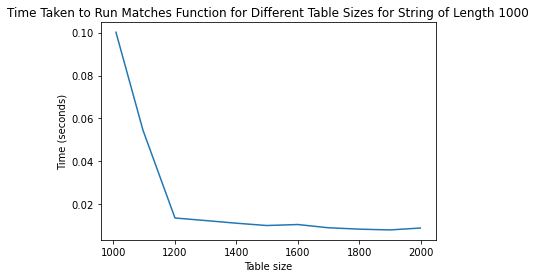

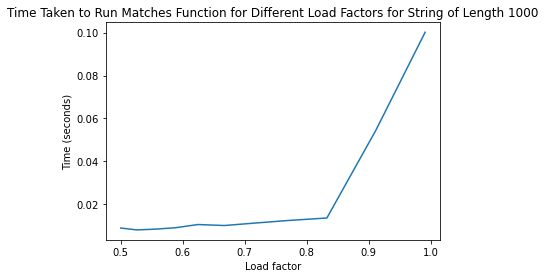

In [11]:
import matplotlib.pyplot as plt
import time

# table sizes ranging from load factor ~1 to ~0.5
table_sizes = [1009, 1097, 1201, 1301, 1399, 1499, 1601, 1699, 1801, 1901, 1999]
times_for_each = [0 for i in range(len(table_sizes))]
times = []
n = 10

for i in range(n):
    
    random_string_1 = ''
    random_string_2 = ''
    for i in range(1000):
        random_string_1 += chr(random.randint(97, 122))
        random_string_2 += chr(random.randint(97, 122))
    
    for i in range(len(table_sizes)):
        start = time.time()
        regular_get_match(random_string_1, random_string_2, 3, table_sizes[i])
        end = time.time()
        times_for_each[i] += (end-start)

for i in times_for_each:
    times.append(i/n)

# table sizes plot
plt.plot(table_sizes, times, label = 'Table sizes')
plt.xlabel('Table size')
plt.ylabel('Time (seconds)')
plt.title('Time Taken to Run Matches Function for Different Table Sizes for String of Length 1000')
plt.show()

# load factors plot
load_factors = [1000/t for t in table_sizes]
plt.plot(load_factors, times, label = 'Load factor')
plt.xlabel('Load factor')
plt.ylabel('Time (seconds)')
plt.title('Time Taken to Run Matches Function for Different Load Factors for String of Length 1000')
plt.show()

Through testing different table sizes in the same manner as for rh_get_match, we see that a similar load factor is ideal (~0.8). Again, using this kind of load factor will allow us to maintain a balance between memory and time complexities. However, depending on the application, we may wish to increase the table size (giving a smaller load factor) if we want the absolute best runtime, and if we are not short on memory. On the other hand, we may even choose a greater load factor (smaller table size) if we have very limited memory, and if we do not care about runtime, perhaps in the case that string-lengths to input are few and short, as the algorithm will still run quickly for a short input regardless.

#### Observing and Comparing Collisions to rh_get_match

In [12]:
def reg_first_string_table_creator_cols(string, k, base, table_size):
    '''
    Adapted from first_string_table_creator.
    Computes numbers of collisions that occur at each index in hash table.
    Creates a hash table for a string using rolling hashing. When collisions occur, double
    hashing is used to find new indexes.
    
    Parameters
    ----------
    string: str
        string for which to create the table
    k: int
        length of each substring to store in table
    base: int
        to compute hash values
    table_size: int
        size of hash table (must be larger than string length - k, and a prime number)
    
    Returns
    ---------
    collisions: lst
        gives number of collisions that occur in both regular and double hashing for each
        key in hash table
    '''
    #initialise hash table
    keys = [i for i in range(table_size)]
    hash_table = {key: None for key in keys}
    collisions = [0 for i in range(table_size)]

    for i in range(len(string)-k+1):
        substring = string[i:i+k]
        
        prev_hash = djb2_hash(substring, table_size)
        
        # if slot unoccupied, it can be filled
        if hash_table[prev_hash] == None:
            hash_table[prev_hash] = [substring, i]

        # if slot already full, try to find new one using double hashing
        else:
            collisions[prev_hash] += 1
            iterator = 1
            new_index = prev_hash
            hash1 = hash_1(prev_hash, table_size)
            hash2 = hash_2(prev_hash, base, table_size)
                
            # run until unoccupied slot found
            while hash_table[new_index] is not None:

                new_index = (hash1 + iterator*hash2) % table_size
                iterator += 1
                
                # table full!
                if iterator == table_size:
                    raise ValueError('no room left in hash table, increase table size')
            
            # insert at new index found through double hashing
            hash_table[new_index] = [substring, i]

    return collisions

Total number of collisions: 316


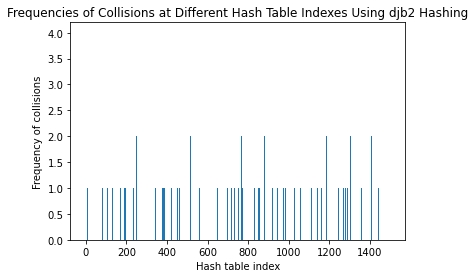

In [13]:
random_string_collisions = ''
for i in range(1000):
    random_string_collisions += chr(random.randint(97, 122))

k = 3
table_size = 1499
base = 50 # does not matter for initial hashing anymore, only used in collisions 

collisions = reg_first_string_table_creator_cols(random_string_collisions, k, base, table_size)
print('Total number of collisions:', sum(collisions))
plt.bar([i for i in range(table_size)], collisions)
plt.xlabel('Hash table index')
plt.ylabel('Frequency of collisions')
plt.title('Frequencies of Collisions at Different Hash Table Indexes Using djb2 Hashing')
plt.show()

Considering the distribution and total frequency of collisions in regular hashing, we see that the overall number of collisions is similar to that of the best case in rolling hashing. Furthermore, the hash value collisions are uniformly-distributed (there is no clustering around particular values, and the peaks spread the entire range of possible values). We can rerun the above cell to see if the distribution changes, which it does, but remains uniform.

#### What Makes a Good Hash Function

An optimal hash function should produce any value in the range of the hash table with equal probability. It should do this in an algorithmic manner, taking the key (or substring in this case), and outputting a number which can be the key in the hash table. A good way to do this is often through the use of prime numbers, which prevent cyclical values occuring. However this is achieved, the keys produced should look completely random. This even distribution helps to prevent clustering, which can harm the O(1) operations of a hash table by:
* causing more collisions to occur at certain keys in the table and probing sequences increase (can no longer assume operations are O(1) as a consequence)
* storing too many values at certain positions in chaining that we must then search through for our value (lookup no longer O(1))

The djb2 hash function, as used above, uses the prime numbers 5381 and 33 to generate pseudo-random hash keys to place into the table, producing evenly-distributed entries into the table, reducing clustering and collisions, and therefore average time complexity.

3. Carefully describe how you would use the code above to investigate the extent of plagiarism. Enumerate potential pitfalls and challenges of applying this algorithm for real-life use (you can also compare both of these algorithms with a more brute-force approach to plagiarism detection; if you do this, make sure to describe how such approach would work and why it wouldn’t be very appealing from a computational standpoint). Make sure you justify all the assumptions you make.

In order to investigate the extent of plagiarism, the above code could be used, specifying k as the length of the strings you would like to match. Using a k of about 40 may (~7 words) give a good overview of phrases that match between the 2 strings. To produce a more complex algorithm that determines a plagiarism score/similarity score between 2 texts, we could use rh_get_match or regular_get_match to produce a list of matching strings, then determine the percentage of text x that is the same as text y. This method may work well for applications such as professors checking for plagiarism between students work.

Considering a brute force approach to plagiarism detection, we may create the most simple algorithm that moves along string x stepwise, and compares each substring of length k to every substring in y, looking for matches in substrings (see below for a brute force implementation). This, however, is not very computationally appealing as we can no longer simply lookup a substring in O(1) time, but instead must compare this substring to every substring in the other string (more on time complexity discussed below). This does not, however, take up much memory (less than the above algorithms) as we need not store the hash table. Therefore, we may choose this approach if we are short on memory, and if we have short string lengths to compare (as the time will be low regardless of the algorithm for short inputs). In the case where we require long string inputs and have enough memory, however, the rolling and regular hashing methods would likely be better.

4. Discuss the time complexity of each algorithmic version. Compare and contrast the two versions by experimenting on self-generated inputs. You are encouraged to generate inputs of various natures as that would be more likely to tease out the strengths and/or weaknesses of the versions.

In [14]:
def brute_force_matches(x, y, k):
    '''
    Compares all substrings between x and y by sliding along x, comparing each 
    substring to all substrings in y.
    
    Parameters
    ----------
    x: str
        first string for which to find matches
    y: str
        second string for which to find matches
    k: int
        length of substrings to compare
        
    Returns
    ---------
    matches: lst
        list of tuples containing indexes that contain matching substrings between x and y
    '''
    matches = []
    
    # number of substrings in x
    for i in range(len(x)-k+1):
        
        # from position of substring in x to end of y
        for j in range(i, len(y)-k+1):
            
            if x[i:i+k] == y[j:j+k]:
                matches.append((i, j))
    
    return matches

In [15]:
random_string_1 = ''
random_string_2 = ''
for i in range(1000):
    # full range of ascii capitals, lowercase, numbers, and some symbols 
    random_string_1 += chr(random.randint(48, 122))
    random_string_2 += chr(random.randint(48, 122))

random_string_1 = clean_string(random_string_1)
random_string_1 = clean_string(random_string_2)

k = 4
matches_1 = brute_force_matches(random_string_1, random_string_2, k)

for m in matches_1:
    assert random_string_1[m[0]:m[0]+k] == random_string_2[m[1]:m[1]+k]

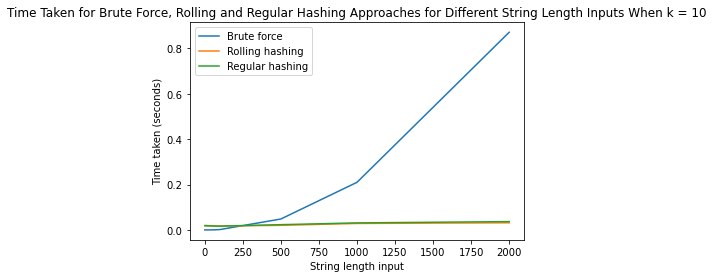

In [16]:
n = 10 # repetitions 
k = 10 # string length

string_lengths = [0, 10, 50, 100, 500, 1000, 2000]
brute_times = [0, 0, 0, 0, 0, 0, 0]
rolling_times = [0, 0, 0, 0, 0, 0, 0]
regular_times = [0, 0, 0, 0, 0, 0, 0]

for i in range(n):
    for j in range(len(string_lengths)):
        
        # new random strings every time
        random_string_1 = ''
        random_string_2 = ''
        for l in range(string_lengths[j]):
            random_string_1 += chr(random.randint(97, 122))
            random_string_2 += chr(random.randint(97, 122))
        
        start = time.time()
        brute_force_matches(random_string_1, random_string_2, k)
        end = time.time()
        brute_times[j] += (end-start)
        
        start = time.time()
        rh_get_match(random_string_1, random_string_2, k)
        end = time.time()
        rolling_times[j] += (end-start)
        
        start = time.time()
        regular_get_match(random_string_1, random_string_2, k)
        end = time.time()
        regular_times[j] += (end-start)

# compute averages
brute_times = [t/n for t in brute_times]
rolling_times = [t/n for t in rolling_times]
regular_times = [t/n for t in regular_times]

plt.plot(string_lengths, brute_times, label = 'Brute force')
plt.plot(string_lengths, rolling_times, label = 'Rolling hashing')
plt.plot(string_lengths, regular_times, label = 'Regular hashing')
plt.legend()
plt.xlabel('String length input')
plt.ylabel('Time taken (seconds)')
plt.title('Time Taken for Brute Force, Rolling and Regular Hashing Approaches for Different String Length Inputs When k = 10')
plt.show()

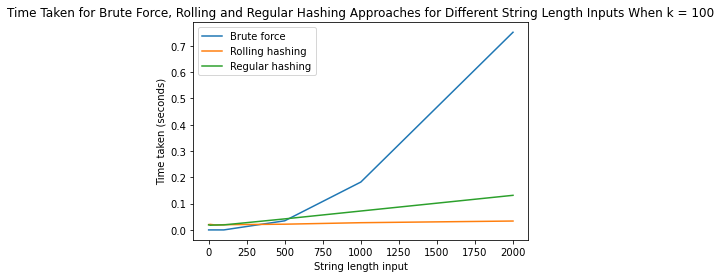

In [17]:
n = 10 # repetitions 
k = 100 # string length

string_lengths = [0, 10, 50, 100, 500, 1000, 2000]
brute_times = [0, 0, 0, 0, 0, 0, 0]
rolling_times = [0, 0, 0, 0, 0, 0, 0]
regular_times = [0, 0, 0, 0, 0, 0, 0]

for i in range(n):
    for j in range(len(string_lengths)):
        
        # new random strings every time
        random_string_1 = ''
        random_string_2 = ''
        for l in range(string_lengths[j]):
            random_string_1 += chr(random.randint(97, 122))
            random_string_2 += chr(random.randint(97, 122))
        
        start = time.time()
        brute_force_matches(random_string_1, random_string_2, k)
        end = time.time()
        brute_times[j] += (end-start)
        
        start = time.time()
        rh_get_match(random_string_1, random_string_2, k)
        end = time.time()
        rolling_times[j] += (end-start)
        
        start = time.time()
        regular_get_match(random_string_1, random_string_2, k)
        end = time.time()
        regular_times[j] += (end-start)

# compute averages
brute_times = [t/n for t in brute_times]
rolling_times = [t/n for t in rolling_times]
regular_times = [t/n for t in regular_times]

plt.plot(string_lengths, brute_times, label = 'Brute force')
plt.plot(string_lengths, rolling_times, label = 'Rolling hashing')
plt.plot(string_lengths, regular_times, label = 'Regular hashing')
plt.legend()
plt.xlabel('String length input')
plt.ylabel('Time taken (seconds)')
plt.title('Time Taken for Brute Force, Rolling and Regular Hashing Approaches for Different String Length Inputs When k = 100')
plt.show()

In order to determine and compare the time complexities of each algorithm, I will consider the length of string x as m, and the length of string y as n.

Analytical analysis:
* Rolling hashing- To create the table, we insert each substring of x into it. Each insertion is Omega(1), with the assumptions of uniform hashing being fulfilled as we can see in collision plots in question 1, and the discussion below them, the load factor < 1, and computing each hash value takes Omega(1). Therefore, the overall time complexity to create the table is Omega(m) (m-k insertions) as each substring must be inserted. To lookup in this table takes again Omega(1) time, following the same assumptions as before. We must lookup each substring in y, therefore producing a time complexity of Omega(n) (n-k lookups) for searching the table. The overall time complexity of this algorithm is therefore Omega(m+n), as we may simply sum the 2 parts. In the absolute worst-case scenario, each insertion and lookup could take O(m) or O(n) if many collisions occur, to give an overall complexity of O(m(m+n)), O(m^2) for table creation, and O(mn) for searching. However, due to the uniform hashing in the above implementation, we can assume our algorithm runs in O(m+n) time on average.
* Regular hashing- Unlike rolling hashing, we must compute every hash value from scratch. To compute these hash values takes Omega(k) time, as we must iterate over each character in the substring. The time complexity to create the table will therefore become Omega(km), as we must compute the hash value and insert it for every substring in x. To lookup a substring in the table will become Omega(k) also, due to the computation of the hash value, giving an overall lookup complexity of Omega(kn). Therefore, the overall time complexity for regular hashing will be Omega(k(m+n)). In the absolute worst-case scenario, each insertion and lookup could take O(m) or O(n) if many collisions occur, to give an overall complexity of O(km(m+n)), O(km^2) for table creation, and O(kmn) for searching. However, due to the uniform hashing in the above implementation, we can assume our algorithm runs in O(k(m+n)) time on average.
    * Though this is not as bad as a brute force approach, the constant factor k means that the time complexity is worse for regular hashing. This is a cause of computing each hash value from scratch for each substring. The difference in times between the regular and rolling hashing will therefore likely have a greater effect as k grows larger. For this reason, it may only be applicable to use regular hashing if we are searching for matches of small lengths between the 2 substrings, otherwise rolling hashing will take less time.
* Brute force- Because we compare every single string in x to every string in y, we must multiply the 2 lengths to give a time complexity of Theta(mn), significantly worse than the 2 algorithms above. The time complexity of this algorithm is always the same, regardless of the input.

Graphical analysis:

To produce the above plots, I have varied the lengths of string inputs, and the algorithms observed (the independent variables), and stored the time taken for each input length (the dependent variable). For each plot, I have controlled the size of the hash tables, so as not to affect the number of collisions that occur in both regular and rolling hashing. I have also controlled the values of k for each experiment, so that all 3 algorithms are running for the same inputs. I have changed the value of k between plots to determine the effect that this has on the differences between the time taken for different algorithms (to determine the effect of changing k on the dependent variable).

The outputs agree with compuational analyses, as both rolling and regular hashing produce linear growth, and brute force displays a polynomial growth.

Considering the outputs of the above graphs, it is evident that the analysis above holds, and that rolling hashing perform much better from a time perspective when we increase substring lengths (k) from 10 to 100. For smaller values of k, they are comparable as the loop to compute hash values from scratch must take a similar amount of time to computing the rolling hash values. 

Another interesting output we see is the time taken to run each algorithm for string lengths smaller than ~250. Here, we see that brute force performs better than both rolling and regular hashing. This is likley a cause of the time taken for computations involved in both that provides a constant factor to the time complexities. Therefore, in the case of short string inputs, brute force performs faster. This algorithm therefore may be a better choice in the case we wish to compare small pieces of text.

5.List all the LOs and HCs you have exercised while working on this final assignment as well as a thorough justification of their application. Review your previous assignments and in-class grades, and reflect on your application of these LOS has evolved over time

* #AlgorithmicStrategies- I have explained how my algorithms work, justifying the use of certain features: hashing, rolling hashing, double hashing. In order to fully justify the use of double hashing, I have compared it to other open-addressing techniques (linear and quadratic probing), detailing why it is better than these methods by justifying the underlying techniques used, and therefore why it solves the problem more effectively. I have also compared it to chaining, another method to deal with collisions, again detailing the differences between the 2, and where chaining could be more applicable, but why it is comparable in this specific application. In questions 3 and 4, I have compared my algorithms to a brute force approach to the problem, explaining why the rolling hash approach is the best for most applications by first explaining how the brute force algorithm would work. I have used plots to help explain why the algorithm works, such as the collisions plots. I have shown here than the keys are uniformly-distributed, and used this to explain why the algorithm works.
* #breakitdown- In order to create the rh_get_match function, I had to break it down into different problems: how to create hash functions for strings, how to ensure these hash values were uniformly-distributed, how to use these hash functions to produce a hash table, how to search for substrings in the hash table, how to generate a list of matching indexes between the 2 strings x and y. As you can see, each step depended on the last, meaning it was necessary to break the overall problem down in this way, and work linearly through the problems, debugging the code at each step along the way. If I were to try and solve the overall problem without breaking it down in this way, I may end up with issues that are not relevant to that paricular step. For example, the hash table produced may contain keys greater than the size of the table itself, an issue that would come from hash functions that do not use modq to restrict the key to less than the table size. It may be difficult to debug this issue, as it may be unclear where it is coming from to begin with, whereas if we first ensure that the hash functions are good, this issue will not arise further down the line. Solving individual, more tractable, subproblems in this manner allowed me to not only produce code more efficiently, but also helped me to produce different useful functions that should be more understandable to others trying to read and comprehend my code. 
* #CodeReadability- I have produced code that has a sufficient amount of comments for those trying to comprehend my code, but not so many that it becomes cluttered and difficult to read. The comments explain the function of the code on a deeper level, not merely the code rephrased. I have provided clear, well-formatted docstrings for all of my functions used. I have provided examples of how functions work in docstrings where necessary, to provide a more explicit explanation of the function of the code. I have changed the names of functions when adapting them so that they all have clear definitions. I have also included an error message in the creation of the hash table when all positions are filled, so that the user is able to increase the size of the table for it to function. It would otherwise become difficult to debug. 
* #ComplexityAnalysis- I have derived the complexities of rolling and regular hashing, as well as a brute force approach to the problem as a comparison. I have given detailed explanations of how these complexities arise, referencing functions within the code to demonstrate. I have considered the assumptions I am making within the complexity analysis, concluding why I am able to make these assumptions, and what the worst-case scenario would be (though it would occur by chance, and not be design of the algorithms themselves). I have compared all 3 algorithms' complexities, concluding which may be best for different applications. Furthermore, I have generated plots for the 3 algorithms for 2 different values of k to demonstrate the different behaviours in different situations. I have explained the unexpected outputs for small input values, and therefore why brute force could be a better approach in such situations.
* #ComputationalCritique- In questions 3 and 4, I have compared regular and rolling hashing with a brute force approach to the problem. I have explained how the brute force approach would work, and therefore why it does not work as well as the hashing approaches. I have compared both the space and time elements, and therefore explained why brute force may be a better option in specific cases (short string inputs, not much memory available). I have justified these conclusions using plots to generate outputs for different substring lengths, allowing me to show that the brute force approach could work better when the input strings are very short. Furthermore, in question 1, I have justified why we choose to use hashing for such a problem in the first place, and the power that this method holds that others do not.
* #DataStructures- I have compared and contrasted the use of the hashing technique with a brute force approach to the problem, explaining why the use of no data structures in a brute force gives a worse out come (worse time complexity). I have also justified the use of hashing in question 1, explaining why it is a good method for this application, and how it allows us to insert and lookup in O(1) time. I have further explained the assumptions we are making to get this time complexity, and howwe can ensure these assumptions hold in the algorithm. In question 1, I have also discussed an alternative to the hash table method (trie trees), explained how this would work for the application, and why it is not necessary. I have also discussed the potential time complexity of such an approach.
* #PythonProgramming- I have produced working code for 3 different algorithms to detect plagiarism. I have provided test cases to show that my code is working, including many edge cases which are justified in the code comments. I have used randomly-generated strings with many different characters and numbers to test my code, which can be run multiple times if needed to generate many different test cases. I have also produced code to compare between my algorithms in the final question, generating plots that allow me to explain the time complexities, and any unexpected outputs that could lead to specific conclusions.
* #utility- I have used the principles of utility to weigh up the advantages and disadvantages of the 3 algorithms implemented, and therefore draw conclusions about the best applications for each. For example, in question 4, I have considered the experimental outputs of the algorithms, allowing me to conclude that the brute force approach could be more advantageous for small string inputs. I have also considered the space complexity of the different algorithms, and other features that make different ones better for different applications. I have also considered the advantages and limitations of open addressing (double hashing) versus chaining to overcome the issue of collisions. I have weighed up these, allowing me to explain why I have chosen double hashing as the option with the greatest utility for this specific application. I have also explained why for different applications in which deletion from the hash table is necessary, chaining may be a better approach.
* #variables- In question 4, in the experimental analysis, I have defined the dependent, independent, and controll variables in my experiments. I have explained why the control variables musts remain constant to be able to accurately compare between algorithms. I have used these definitions to then compare the different algorithms in a fair manner, in which all were under the same conditions so that no bias was displayed.

#### Reflection of LO Applications
* #AlgorithmicStrategies- I have found this LO the most difficult, especially at the beginning of the semester when I mainly just explained the code. I now believe that I am able to understand and explain algorithms on a deeper level, detailing how and why a specific approach works.
* #CodeReadability- I have never written docstrings prior to this class, and my comments mainly consisted of re-explaining the code in natural language. Over the course of the semester, I believe I have learned the importance of and how to appropriately create docstrings and comments which highlight the strategy of the code.
* #ComplexityAnalysis- I have found this LO one of the most difficult, mainly in finding the correct metric by which to measure a complexity. However, I believe that I have learned much about how to define complexities in a way in which I can compare them between different algorithms.
* #ComputationalCritique- I think that I am now equipped with many different tools to be able to compare different algorithms. After taking CS110, I am now able to consider many factors (eg. space, time) and not just which may be easier to implement.
* #DataStructures- Over the course of the semester, I have improved my skills in applying data structures. I have learned how to use many new data structures, and also how to compare between them for different applications, and draw conclusions about which ones are best in different situations.
* #PythonProgramming- I think that I have definitely improved in this LO over the course of the semester. To begin with, my main aim in solving a problem was to produce working code, but now I believe I am focussing also on creating code using the most appropriate data structures and algorithmic strategies to effectively solve the problem.